### Prepare Notebook
Install dependencies, download dataset.

In [1]:
%%capture
! pip install pdf2image
! pip install pytesseract
! apt install poppler-utils
! apt install tesseract-ocr
! pip install -U langchain openai chromadb langchain-experimental
! pip install "unstructured[all-docs]==0.10.19" pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch
! pip install onnxruntime==1.15.1

In [2]:
! wget "https://www.blm.gov/sites/blm.gov/files/uploads/gis-s1mobile-device-specs.pdf"

--2025-01-16 03:02:53--  https://www.blm.gov/sites/blm.gov/files/uploads/gis-s1mobile-device-specs.pdf
Resolving www.blm.gov (www.blm.gov)... 204.124.92.179, 2001:49c8:8004:20fc::92:179
Connecting to www.blm.gov (www.blm.gov)|204.124.92.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1228892 (1.2M) [application/pdf]
Saving to: ‘gis-s1mobile-device-specs.pdf’

gis-s1mobile-device 100%[===================>]   1.17M  1.67MB/s    in 0.7s    

2025-01-16 03:02:55 (1.67 MB/s) - ‘gis-s1mobile-device-specs.pdf’ saved [1228892/1228892]



### Imports

In [3]:
import os
import shutil
import base64
import io
from operator import itemgetter
import numpy as np
from PIL import Image
from PIL import Image as _PILImage

from langchain.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough,RunnableParallel
from langchain.vectorstores import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings
import chromadb

from unstructured.partition.pdf import partition_pdf

In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

### Data Preparation

In [4]:
PDF_NAME = 'gis-s1mobile-device-specs.pdf'
IMG_PATH = 'imgs/'

In [20]:
raw_pdf_elements = partition_pdf(filename=PDF_NAME,
                                 extract_images_in_pdf=True,
                                 infer_table_structure=True,
                                 chunking_strategy="by_title",
                                 max_characters=4000,
                                 new_after_n_chars=3800,
                                 combine_text_under_n_chars=2000,
                                 image_output_dir_path=IMG_PATH,)

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))
print(len(tables))
print(len(texts))

6
56


In [ ]:
img_uris = sorted([os.path.join(IMG_PATH, image_name) for image_name in os.listdir(IMG_PATH) if image_name.endswith(".jpg")])

#### Example
Extracted image from the pdf, along with its description.

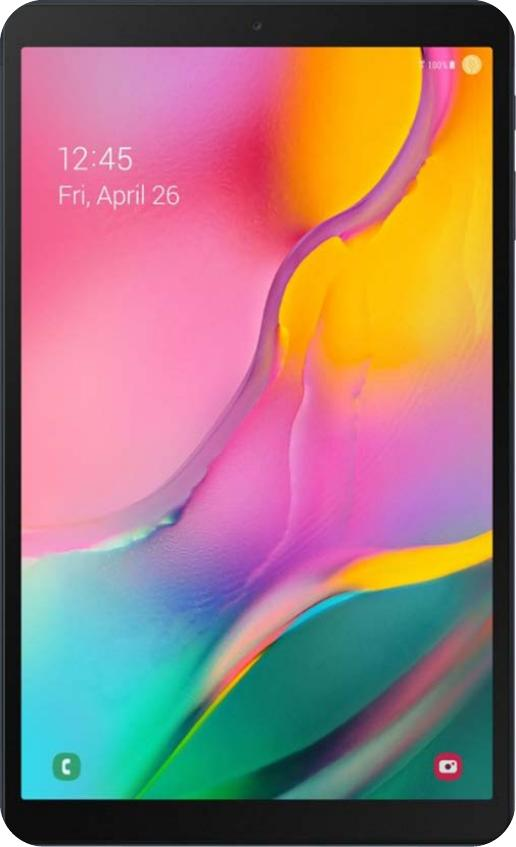

In [23]:
Image.open(f'{IMG_PATH}figure-21-4.jpg')


### Vector Database
Initialize a Chroma DB and insert images and description.

In [ ]:
vector_db = Chroma(collection_name="img_desc", embedding_function=OpenCLIPEmbeddings())

open_clip_pytorch_model.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

In [ ]:
vector_db.add_images(uris=img_uris)
vector_db.add_texts(texts=texts)
retriever = vector_db.as_retriever()

### Prompt
Connecting to GPT4 model, writing the prompt, preprocessing a user input

In [ ]:
PROMPT = {"type": "text",
          "text": (
            "As an tech device assistant, your task is to analyze and interpret images of certain device and describe the appearence"
            "Alongside the images, you will be "
            "provided with related text to offer device charachteristics. Both will be retrieved from a vectorstore based "
            "on user-input keywords. Please use your extensive knowledge and analytical skills to provide a "
            "comprehensive summary of the device wanted by user(not use other devices) that includes:\n"
            "- A detailed description of the mentioned device in the image.\n"
            "- Connections between the image and the related text.\n\n"
            "- Provide as many details as posible from the text.\n"
            "User-provided keywords: {question}\n\n"
            "Text and / or tables:\n"
            "{formatted_texts}"),}

In [24]:
def resize_base64_image(base64_string, size=(128, 128)):
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    resized_img = img.resize(size, Image.LANCZOS)
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    return base64.b64encode(buffered.getvalue()).decode("utf-8")

def is_base64(s):
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False

def split_data(docs):
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content
        if is_base64(doc):
            images.append(resize_base64_image(doc, size=(250, 250)))
        else:
            text.append(doc)
    return {"images": images, "texts": text}

In [25]:
def prompt_func(data_dict):
    # Joining the context texts into a single string
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"
            },
        }
        messages.append(image_message)

    text_message = PROMPT.format(question=data_dict['question'],
                                 formatted_texts=formatted_texts)
    messages.append(text_message)

    return [HumanMessage(content=messages)]

In [ ]:
model = ChatOpenAI(temperature=0,
                   model="gpt-4-vision-preview",
                   max_tokens=1024)

chain = ({"context": retriever | RunnableLambda(split_data),
          "question": RunnablePassthrough(),}
         | RunnableParallel({"response":prompt_func| model,
                             "context": itemgetter("context"),}))

### Result

In [ ]:
response = chain.invoke("Juniper Systems Geode Bluetooth Receiver")

In [ ]:
response['response']

AIMessage(content="The Juniper Systems Geode Bluetooth Receiver is a compact and lightweight device designed for high-accuracy location tracking. It is compatible with a variety of mobile devices, including Samsung Galaxy Note 10, Samsung Tab A 7” (2014), Samsung Tab S2, Samsung Galaxy S8, Samsung Galaxy Note8, Samsung Tab A 10.1” (2019), Samsung Tab A 8” (2019), Samsung Tab S5E, Samsung Galaxy S10, Samsung Galaxy S10+, and Samsung Tab Active 2.\n\nThe Geode Bluetooth Receiver has a size of 4.4 in x 4.4 in x 1.7 in and weighs 12.7 oz. It utilizes GPS, GLONASS, and SBAS location sources to provide an accuracy of 3.2 meters in open sky and 5.3 meters in closed canopy environments. The device is rugged and designed for use in various field conditions.\n\nThe related text also mentions a summary of 2019 device accuracy results from a GPS course in Clackamas with heavy canopy, indicating the Geode's performance in challenging environments. Additionally, the text includes a website link for 

In [ ]:
response['context']['texts']

['Samsung Galaxy Note 10 .......................................................................................................................... 2\n\nJuniper Systems Geode Bluetooth Receiver ........................................................................................... 15\n\nTrimble R1 Bluetooth Receiver ............................................................................................................... 14\n\nSamsung Tab A 7” (2014) ........................................................................................................................ 13\n\nSamsung Tab S2 ...................................................................................................................................... 12\n\nSamsung Galaxy S8 ................................................................................................................................. 11\n\nSamsung Galaxy Note8 ..............................................................................

In [ ]:
img = response['context']['texts'][-1]


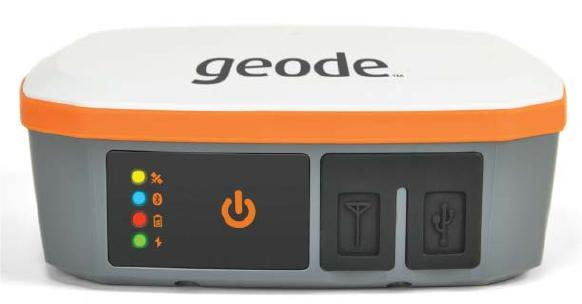

In [ ]:
def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

plt_img_base64(img)